# Data Based Vehicle Energy Consumption Modeling
---
* In this project, we have a real data set at hand which consists of various features regarding driving profiles of electric delivery trucks. The goal of this project is to investigate this data, and better understand some characteristics of electric vehicles as well as their energy consumption.

* This is a data analysis project. The students will

> 1.  Perform data cleaning and preprocessing
> 2.  Perform clustering to catch some patterns in the data
> 3.  Use concepts from machine learning for a detailed investigation of the data
> 4.  Perform visualization to present the outcomes of their investigation

*   **Students**: Mert Kılıçaslan, Serhan Yorulmaz, Yunus Delipınar
*   **Supervisors**: Tuğçe Yüksel, Öznur Taştan, Mert Özçelik

## 0.1. Import Libraries

In [33]:
from os.path import join
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.integrate import trapz
pd.options.mode.chained_assignment = None

In [216]:
#from google.colab import drive
#drive.mount('/content/drive')

## 0.2. Understanding data

In [34]:
# Shortcut of the 'ENS491 / F22' file must be added to My Drive
path_prefix = "../Smith_Gen2 Vehicles Data/vehicle_106"
fname = "device_06A_2013-01-03" 

In [35]:
mat = loadmat(join(path_prefix, fname))
mat = {k:v for k, v in mat.items() if k[0] != '_'}
df = pd.DataFrame({k: np.array(v).flatten() for k, v in mat.items()})

df.head()

,Act1_Iacm_CA,Act1_Iacm_CB,ms_nmot,Lowest_Cell_Voltage_SBS3,Lowest_Cell_Voltage_SBS2,Lowest_Cell_Voltage_SBS1,Lowest_Cell_Voltage_SBS6,Lowest_Cell_Voltage_SBS5,VS_DCMD,SOC_SYS,...,BMU_Mode_SYS,CT_Air_Con_Current_RD,ms_tmc1,Lowest_Cell_Temperature_SBS6,ms_ths5,vs_bcmd,GPS_Longitude,ms_ths1,ms_ths3,ms_ths2
0,NaN,NaN,NaN,3291.0,3292.0,3292.0,NaN,NaN,NaN,NaN,...,2.0,2874.0,NaN,NaN,NaN,NaN,-73.952771,NaN,NaN,NaN
1,NaN,NaN,NaN,3287.0,3288.0,3288.0,NaN,NaN,NaN,NaN,...,2.0,2951.0,NaN,NaN,NaN,NaN,-73.952765,NaN,NaN,NaN
2,NaN,NaN,NaN,3289.0,3290.0,3291.0,NaN,NaN,NaN,NaN,...,2.0,2842.0,NaN,NaN,NaN,NaN,-73.952761,NaN,NaN,NaN
3,NaN,NaN,NaN,3293.0,3293.0,3294.0,NaN,NaN,NaN,NaN,...,2.0,2752.0,NaN,NaN,NaN,NaN,-73.952755,16.0,NaN,NaN
4,NaN,NaN,NaN,3295.0,3296.0,3295.0,NaN,NaN,NaN,NaN,...,2.0,2713.0,NaN,NaN,NaN,NaN,-73.952749,17.0,NaN,NaN


In [ ]:
# [i for i in df.columns]


## 0.3. Taking Relevant Features

In [37]:
# Select the desired columns from the dataframe
df = df[['BMU_Mode_SYS','GPS_Speed','Battery_Voltage_SYS','Battery_Current_SYS','Timestamp','RD_Ambient_Temp_degC', "SOC_SYS", "CT_Air_Con_Current_RD", "CT_Heater_Current_RD",'GPS_Altitude']]

# Time decryption (np.float64 to dateTime)
df["Timestamp"] = pd.to_datetime(df['Timestamp'], unit='s')

# Calculate the second difference between current and next row convert into date time seconds
df['Seconds difference'] = df['Timestamp'].diff().dt.total_seconds()

# Calculate the cumulative sum of the time differences for total duration
df['Total Time(s)'] = df['Seconds difference'].cumsum()
df.at[0, "Total Time(s)"] = 0 # Index 0 to NaN value for the first row

# Calculate the second difference between current and next row convert into date time seconds
df['Altitude_diff'] = df['GPS_Altitude'].diff()
df.at[0, "Altitude_diff"] = 0

# Multiplying current and voltage to find power consumption
df['Power(w)'] = df['Battery_Voltage_SYS'] * df['Battery_Current_SYS'] * -1

# Drop the rows where BMU = 0 or BMU = 1
df = df[df['BMU_Mode_SYS'] == 2.0] # Battery Management Unit

df


,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD,GPS_Altitude,Seconds difference,Total Time(s),Altitude_diff,Power(w)
0,2.0,NaN,342.0,-31.0,2013-01-03 07:00:39,NaN,NaN,2874.0,2842.0,70.0,NaN,0.0,0.0,10602.0
1,2.0,NaN,342.0,-43.0,2013-01-03 07:00:40,NaN,NaN,2951.0,2926.0,70.0,1.0,1.0,0.0,14706.0
2,2.0,NaN,342.0,-36.0,2013-01-03 07:00:41,NaN,NaN,2842.0,2816.0,70.0,1.0,2.0,0.0,12312.0
3,2.0,NaN,342.0,-31.0,2013-01-03 07:00:42,NaN,NaN,2752.0,2732.0,71.0,1.0,3.0,1.0,10602.0
4,2.0,NaN,342.0,-25.0,2013-01-03 07:00:43,NaN,NaN,2713.0,2687.0,71.0,1.0,4.0,0.0,8550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86298,2.0,0.0,344.0,-6.0,2013-01-04 06:58:57,2.0,79.0,2494.0,2475.0,51.0,1.0,86298.0,0.0,2064.0
86299,2.0,0.0,344.0,-6.0,2013-01-04 06:58:58,2.0,79.0,2494.0,2475.0,50.0,1.0,86299.0,-1.0,2064.0
86300,2.0,0.0,344.0,-6.0,2013-01-04 06:58:59,2.0,79.0,2494.0,2475.0,50.0,1.0,86300.0,0.0,2064.0
86301,2.0,0.0,344.0,-6.0,2013-01-04 06:59:00,2.0,79.0,2494.0,2481.0,50.0,1.0,86301.0,0.0,2064.0


## 0.4. Advanced Operations (Splitting Trips)

In [ ]:
# Partiton the data to trips by using Total Time(s)
df_trip = df
df_trip['Trip_diff'] = df_trip["Total Time(s)"].diff()
df_trip["Trip"] = (df_trip['Trip_diff'] > 1000).cumsum() + 1

# df_trip


In [21]:
#Displays the acquired trips and their statistics
df_statistics = df_trip.groupby(['Trip'])
counts = df_statistics.size().to_frame(name='Counts')

df_statistics = (counts.join(df_statistics.agg({'GPS_Speed': 'mean'}).rename(columns={'GPS_Speed': 'GPS_Speed_mean'})).
 join(df_statistics.agg({'GPS_Speed': 'median'}).rename(columns={'GPS_Speed': 'GPS_Speed_median'})).
 join(df_statistics.agg({'GPS_Speed': 'min'}).rename(columns={'GPS_Speed': 'GPS_Speed_min'})).
 join(df_statistics.agg({'Battery_Current_SYS': 'mean'}).rename(columns={'Battery_Current_SYS': 'Battery_Current_SYS_mean'})).
 join(df_statistics.agg({'Battery_Current_SYS': 'median'}).rename(columns={'Battery_Current_SYS': 'Battery_Current_SYS_median'})).
 join(df_statistics.agg({'Battery_Current_SYS': 'min'}).rename(columns={'Battery_Current_SYS': 'Battery_Current_SYS_min'})).
 reset_index())

df_statistics

,Trip,Counts,GPS_Speed_mean,GPS_Speed_median,GPS_Speed_min,Battery_Current_SYS_mean,Battery_Current_SYS_median,Battery_Current_SYS_min
0,1,5417,3.242413,0.0,0.0,-23.888315,-7.0,-394.0
1,2,157,0.063694,0.0,0.0,-9.802548,-9.0,-30.0
2,3,5848,5.707592,0.0,0.0,-37.098495,-6.0,-386.0
3,4,49763,3.324237,5.0,0.0,-9.214356,-4.0,-399.0


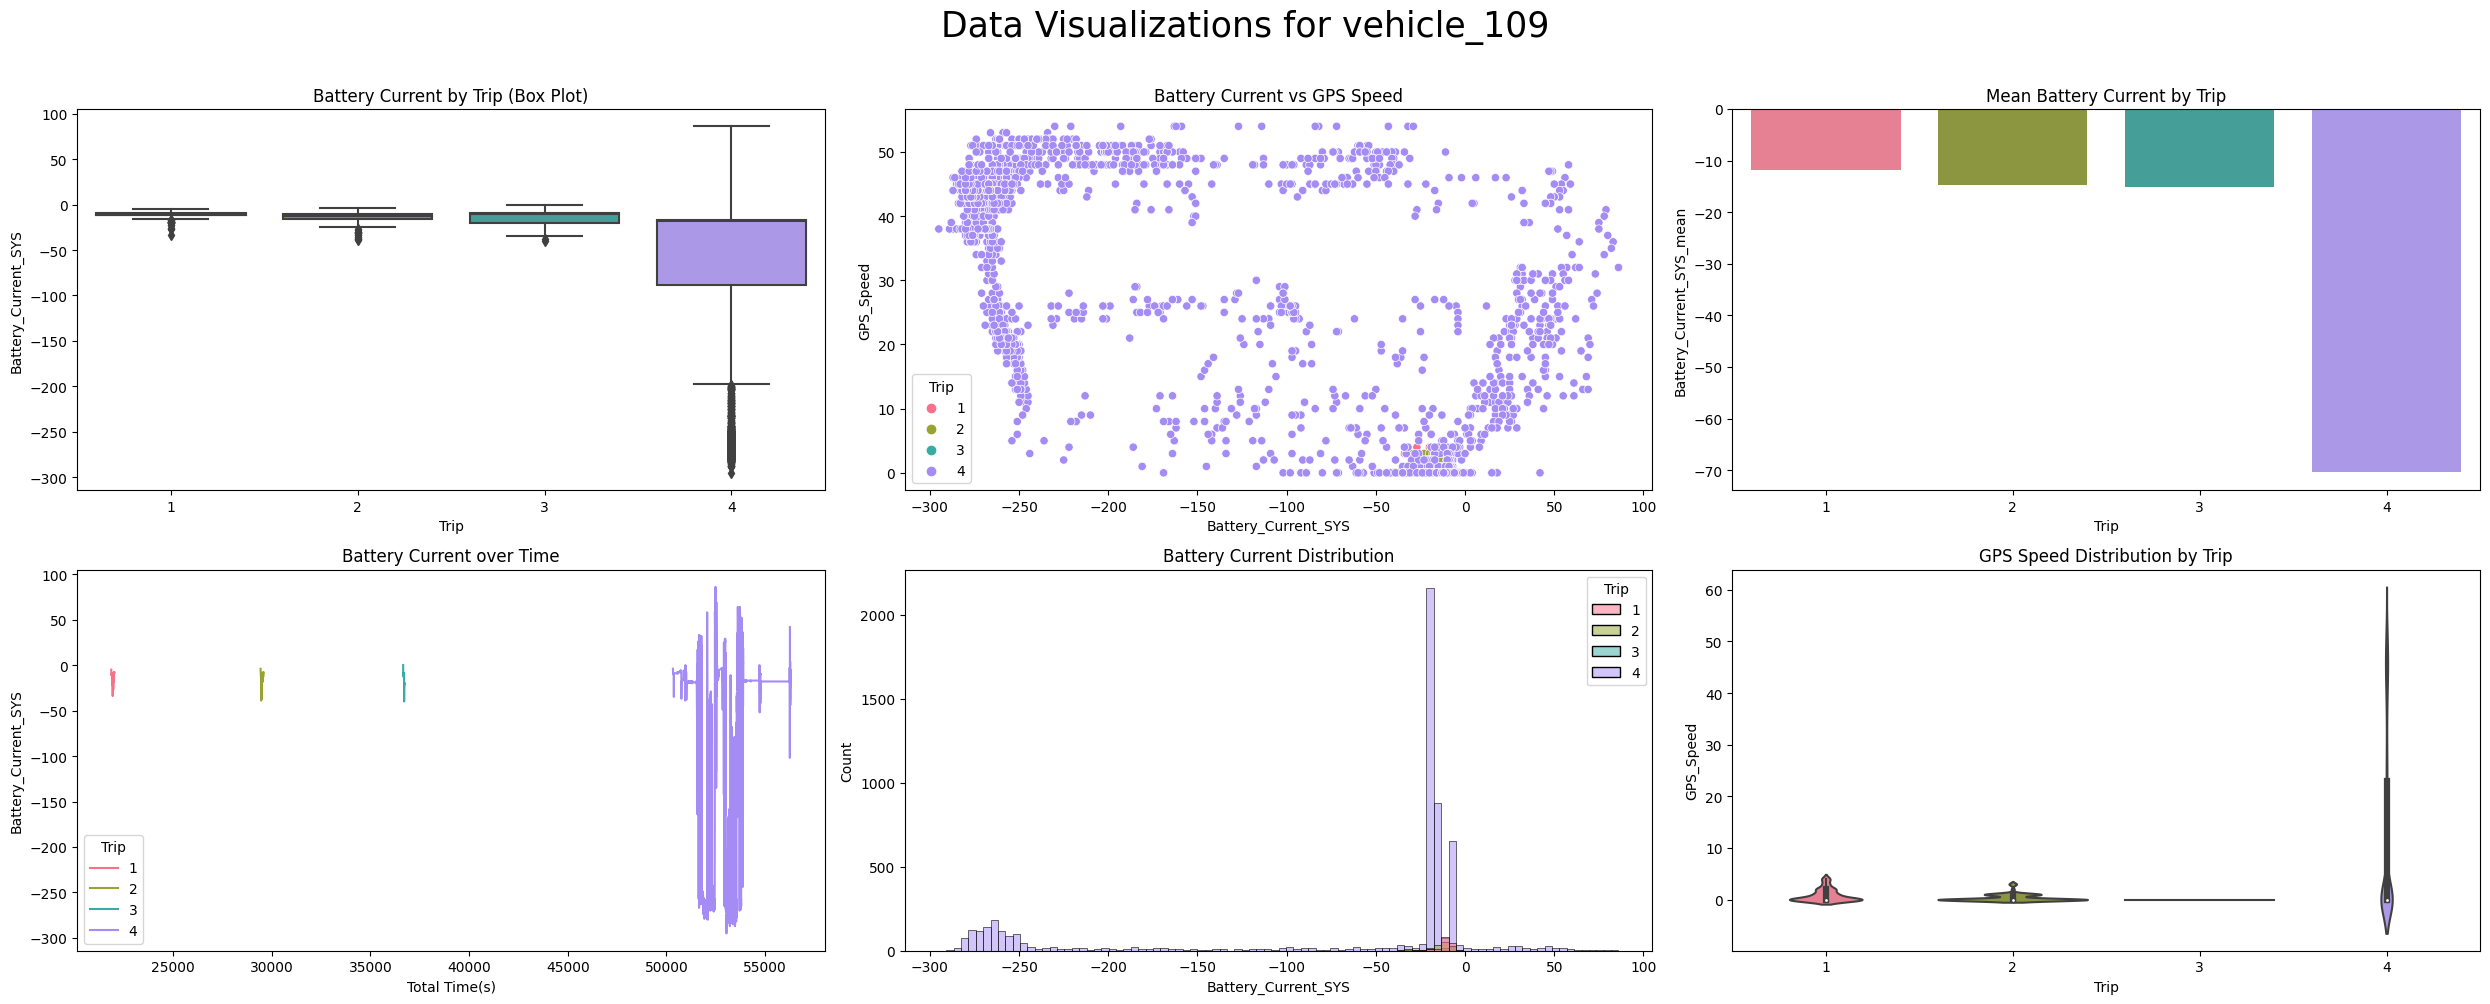

In [227]:
# Create subplots for each plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))
palette = sns.color_palette("husl", len(df_trip["Trip"].unique()))

# Histogram
sns.boxplot(data=df_trip, x="Trip", y="Battery_Current_SYS", palette=palette, ax=axes[0,0])
axes[0,0].set_title("Battery Current by Trip (Box Plot)")

# Scatter plot
sns.scatterplot(data=df_trip, x="Battery_Current_SYS", y="GPS_Speed", hue="Trip", palette=palette, ax=axes[0,1])
axes[0,1].set_title("Battery Current vs GPS Speed")

# Bar plot
sns.barplot(data=df_statistics, x="Trip", y="Battery_Current_SYS_mean", palette=palette, ax=axes[0,2])
axes[0,2].set_title("Mean Battery Current by Trip")

# Additional plot 1
sns.lineplot(data=df_trip, x="Total Time(s)", y="Battery_Current_SYS", hue="Trip", palette=palette, ax=axes[1,0])
axes[1,0].set_title("Battery Current over Time")

# Additional plot 2
sns.histplot(data=df_trip, x="Battery_Current_SYS", hue="Trip", palette=palette, ax=axes[1,1])
axes[1,1].set_title("Battery Current Distribution")

# Additional plot 3
sns.violinplot(data=df_trip, x="Trip", y="GPS_Speed", palette=palette, ax=axes[1,2])
axes[1,2].set_title("GPS Speed Distribution by Trip")

# Add overall title
plt.suptitle("Data Visualizations for " + path_prefix[path_prefix.rfind("/")+1:], fontsize = 25, y= 1)

# Adjust layout and show
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


## 0.5. Merge multiple truck data files


In [41]:
path_prefix = "../Smith_Gen2 Vehicles Data"

In [42]:
cols_to_keep = ['BMU_Mode_SYS','GPS_Speed','Battery_Voltage_SYS','Battery_Current_SYS','Timestamp','RD_Ambient_Temp_degC','GPS_Altitude','CT_Heater_Current_RD','CT_Air_Con_Current_RD']

In [68]:
df_list = [] # Initialize an empty list to store dataframes
SEARCH_VEHICLE_FOLDER_COUNT = 5
vehicle_folder_counter = 0

removed_file_counter = 0

# Iterate over the directories and files in the path_prefix
for path, currentDirectory, files in os.walk(path_prefix):
    # Iterate over the files in the current directory
    print("Reading", os.path.basename(path) + "... ", end="")

    for file in files:
        if file.endswith('.mat'):
            try:
                mat = loadmat(join(path, file))

            except IOError:
                print(f"\nError reading file: {join(path, file)}")
                continue
                
            mat = {k: v for k, v in mat.items() if k[0] != '_'}
            df_temp = pd.DataFrame({k: np.array(v).flatten() for k, v in mat.items()})

            #selecting columns to keep
            df_temp = df_temp[cols_to_keep]
            
            # anomaly detection
            df_anomaly = df_temp[df_temp['BMU_Mode_SYS'] == 2.0]

            if(df_anomaly['RD_Ambient_Temp_degC'].isnull().mean() >= 0.50 or df_anomaly['GPS_Speed'].isnull().mean() >= 0.50 or 
               df_anomaly['Battery_Voltage_SYS'].isnull().mean() >= 0.50 or df_anomaly['Battery_Current_SYS'].isnull().mean() >= 0.50 or 
               df_anomaly['GPS_Altitude'].isnull().mean()>= 0.50 or df_anomaly['CT_Heater_Current_RD'].isnull().mean()>= 0.50 or 
               df_anomaly['CT_Air_Con_Current_RD'].isnull().mean()>= 0.50) :
                removed_file_counter += 1

            else:
                # Convert the 'Timestamp' column to datetime
                # Seconds[n] = Timestamp[n+1] - Timestamp[n]
                df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'], unit='s')
                df_temp['Seconds difference'] = df_temp['Timestamp'].diff().dt.total_seconds()
                df_temp['GPS_Altitude_diff'] = df_temp['GPS_Altitude'].diff()
                df_temp.at[0, "GPS_Altitude_diff"] = 0
                
                # Calculate the cumulative sum of the time differences
                df_temp['Total Time(s)'] = df_temp['Seconds difference'].cumsum()
                df_temp.at[0, "Total Time(s)"] = 0

                # Convert GPS speed from mph to km/h
                df_temp['GPS_Speed'] = df_temp['GPS_Speed'] * 1.60934

                # Calculate the speed difference between consecutive timestamps
                # Calculate acceleration (change in speed / change in time = m/s^2)
                df_temp['Acceleration'] = (df_temp['GPS_Speed'] / 3.6).diff() / df_temp['Seconds difference']
                
                # Calculate power
                df_temp['Power(kW)'] = (df_temp['Battery_Voltage_SYS'] * df_temp['Battery_Current_SYS'] * -1) / 1000

                # Select BMU
                df_temp = df_temp[df_temp['BMU_Mode_SYS'] == 2.0]

                # Assign traffic categories to a new column 'Traffic_Category'
                df_temp['Traffic_Category'] = df_temp['Timestamp'].dt.hour.apply(
                    lambda hour: 1 if 0 <= hour < 5 # Early Morning (12AM - 5AM): Low traffic
                    else 3 if 5 <= hour < 10        # Morning Rush Hour (5AM - 10AM): High traffic
                    else 2 if 10 <= hour < 15       # Midday (10AM - 3PM): Moderate traffic
                    else 3 if 15 <= hour < 20       # Evening Rush Hour (3PM - 8PM): High traffic
                    else 1)                         # Late Evening (8PM - 12AM): Low traffic

                # Partition the data to trips by using Total Time(s)
                # Assign trip numbers based on the difference in 'Total Time(s)'
                df_temp['Trip_diff'] = df_temp["Total Time(s)"].diff()
                df_temp["Trip"] = (df_temp['Trip_diff'] > 1000).cumsum() + 1

                # Create a 'Trip_Seconds_Counter' column without adding intermediate columns to the DataFrame
                df_temp['Trip_Seconds_Counter'] = (
                    df_temp['Trip'].ne(df_temp['Trip'].shift())
                    .cumsum()
                    .groupby(df_temp['Trip'])
                    .cumcount()
                )   
                
                 # DROPPING ANORMALIES First
                df_temp.drop(df_temp[df_temp['GPS_Speed'] >= 50].index, inplace=True)
                df_temp.drop(df_temp[df_temp['Battery_Voltage_SYS'] >= 360].index, inplace=True)
                # df_temp.drop(df_temp[df_temp['Power(kW)'] >= 80].index, inplace=True) Use Volt*Current instead
                df_temp.drop(df_temp[df_temp['RD_Ambient_Temp_degC'] >= 36].index, inplace=True)
                df_temp.drop(df_temp[df_temp['RD_Ambient_Temp_degC'] < -15].index, inplace=True)
                      
                # Create the vehicle_name extracting from path 
                # Insert the 'ID' and 'File_Name' columns 
                df_temp["ID"] = os.path.basename(path) + '_' + file[file.rfind("_")+1:file.rfind(".")] + "_trip_" + df_temp["Trip"].astype(str)
                df_temp["File_Name"] = os.path.basename(path) + '_' + file

                # Drop the 'Unnecessary' column
                df_temp = df_temp.dropna(subset=['Power(kW)']) 
                df_temp = df_temp.drop(['Trip_diff'], axis=1)
                df_temp = df_temp.drop(['Seconds difference'], axis=1)
                df_temp = df_temp.drop(['BMU_Mode_SYS'], axis=1)
                df_temp = df_temp.drop(['Trip'], axis=1)
                df_temp = df_temp.drop(['Total Time(s)'], axis=1)
                # df_temp = df_temp.drop(['File_Name'], axis=1)

                # Append the dataframe to the list
                df_list.append(df_temp)
                
    print(u'\u2713')

    # the condition below for debug purposes, comment/uncomment if necessary
    if vehicle_folder_counter >= SEARCH_VEHICLE_FOLDER_COUNT:
        break
    vehicle_folder_counter += 1

# Merge all dataframes in the list
print(removed_file_counter, 'files removed due to high NaN ratio')
print("Merging the files... ")
df_merged = pd.concat(df_list)
print("Files have been merged", u'\u2713')

Reading Smith_Gen2 Vehicles Data... ✓
Reading vehicle_106... ✓
Reading vehicle_109... ✓
Reading vehicle_113... ✓
Reading vehicle_150... ✓
Reading vehicle_163... ✓
873 files removed due to high NaN ratio
Merging the files... 
Files have been merged ✓


In [69]:
df_merged

,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,GPS_Altitude,CT_Heater_Current_RD,CT_Air_Con_Current_RD,Acceleration,Power(kW),Traffic_Category,Trip_Seconds_Counter,ID,File_Name
0,0.0,348.0,-11.0,2013-01-02 17:03:03,-5.0,2.0,2475.0,2494.0,NaN,3.828,3,0,vehicle_106_2013-01-02_trip_1,vehicle_106_device_06A_2013-01-02.mat
1,0.0,348.0,-11.0,2013-01-02 17:03:04,-5.0,2.0,2475.0,2500.0,0.0,3.828,3,1,vehicle_106_2013-01-02_trip_1,vehicle_106_device_06A_2013-01-02.mat
2,0.0,348.0,-11.0,2013-01-02 17:03:05,-5.0,2.0,2481.0,2500.0,0.0,3.828,3,2,vehicle_106_2013-01-02_trip_1,vehicle_106_device_06A_2013-01-02.mat
3,0.0,348.0,-11.0,2013-01-02 17:03:06,-5.0,2.0,2481.0,2500.0,0.0,3.828,3,3,vehicle_106_2013-01-02_trip_1,vehicle_106_device_06A_2013-01-02.mat
4,0.0,348.0,-11.0,2013-01-02 17:03:07,-5.0,2.0,2481.0,2500.0,0.0,3.828,3,4,vehicle_106_2013-01-02_trip_1,vehicle_106_device_06A_2013-01-02.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81235,0.0,346.0,-14.0,2015-01-07 06:49:50,14.0,0.0,6.0,2468.0,0.0,4.844,3,134,vehicle_163_2015-01-06_trip_11,vehicle_163_device_0A3_2015-01-06.mat
81236,0.0,346.0,-14.0,2015-01-07 06:49:51,14.0,0.0,6.0,2468.0,0.0,4.844,3,135,vehicle_163_2015-01-06_trip_11,vehicle_163_device_0A3_2015-01-06.mat
81237,0.0,346.0,-7.0,2015-01-07 06:49:52,14.0,0.0,6.0,2468.0,0.0,2.422,3,136,vehicle_163_2015-01-06_trip_11,vehicle_163_device_0A3_2015-01-06.mat
81238,0.0,346.0,-6.0,2015-01-07 06:49:53,14.0,0.0,6.0,2468.0,0.0,2.076,3,137,vehicle_163_2015-01-06_trip_11,vehicle_163_device_0A3_2015-01-06.mat


In [70]:
df_merged.isna().sum()

GPS_Speed                49098
Battery_Voltage_SYS          0
Battery_Current_SYS          0
Timestamp                    0
RD_Ambient_Temp_degC     53156
GPS_Altitude             49886
CT_Heater_Current_RD     69307
CT_Air_Con_Current_RD    52856
Acceleration             49715
Power(kW)                    0
Traffic_Category             0
Trip_Seconds_Counter         0
ID                           0
File_Name                    0
dtype: int64

In [54]:
df_merged['GPS_Speed'] = df_merged['GPS_Speed'].fillna(0)

## 0.6. Groupby trips and create our real dataset

In [75]:
# Custom function to calculate trip metrics
def calculate_trip_metrics(df):
    energy_consumption = np.trapz(y=df["Power(kW)"], x=df["Trip_Seconds_Counter"])
    energy_consumption_kwh = energy_consumption / 3600
    gps_altitude_diff = df["GPS_Altitude"].diff()

    avg_temperature = df["RD_Ambient_Temp_degC"].mean()
    avg_speed_kmh = df["GPS_Speed"].mean(skipna=True)
    avg_traffic_category = df["Traffic_Category"].mean()
    avg_gps_altitude = gps_altitude_diff.mean()
    avg_heater = df["CT_Heater_Current_RD"].mean()
    avg_air = df["CT_Air_Con_Current_RD"].mean()

    # Calculate separate means of positive and negative acceleration values, all of them in m/s^2
    positive_acceleration_mean = df[df["Acceleration"] > 0]["Acceleration"].mean()
    negative_acceleration_mean = df[df["Acceleration"] < 0]["Acceleration"].mean()

    positive_acceleration_sum = df[df["Acceleration"] > 0]["Acceleration"].sum()
    negative_acceleration_sum = df[df["Acceleration"] < 0]["Acceleration"].sum()
    
    positive_altitude_diff_mean = df[df["GPS_Altitude_diff"] > 0]["GPS_Altitude_diff"].mean()
    negative_altitude_diff_mean = df[df["GPS_Altitude_diff"] < 0]["GPS_Altitude_diff"].mean()

    positive_altitude_diff_sum = df[df["GPS_Altitude_diff"] > 0]["GPS_Altitude_diff"].sum()
    negative_altitude_diff_sum = df[df["GPS_Altitude_diff"] < 0]["GPS_Altitude_diff"].sum()

    # positive_altitude_diff_mean = gps_altitude_diff[gps_altitude_diff > 0].mean()
    # negative_altitude_diff_mean = gps_altitude_diff[gps_altitude_diff < 0].mean()
    
    # positive_altitude_diff_sum = gps_altitude_diff[gps_altitude_diff > 0].sum()
    # negative_altitude_diff_sum = gps_altitude_diff[gps_altitude_diff < 0].sum()

    # Get start time and end time for each trip
    start_time = df["Timestamp"].iloc[0]
    end_time = df["Timestamp"].iloc[-1]

    # Calculate max and min speed for each trip
    max_speed = df["GPS_Speed"].max()
    min_speed = df["GPS_Speed"].min()

    # max_altitude_diff = gps_altitude_diff.max()
    max_altitude_diff = df["GPS_Altitude_diff"].max()
    max_altitude = df["GPS_Altitude"].max()

    # min_altitude_diff = gps_altitude_diff.min()
    min_altitude_diff = df["GPS_Altitude_diff"].min()
    min_altitude = df["GPS_Altitude"].min()

    # Calculation of total distance in km
    duration = df["Trip_Seconds_Counter"].max()
    gps_speed_kms = df["GPS_Speed"] / 3600
    total_distance_km = np.trapz(y=gps_speed_kms, x=df["Trip_Seconds_Counter"])

    # Return the calculated metrics for the trip
    return {
        'Energy_Consumption_kWh': energy_consumption_kwh,
        'Start_Time': start_time,
        'End_Time': end_time,
        'Duration_s': duration,
        'Average_Speed_kmh': avg_speed_kmh,
        'Total_Distance_km': total_distance_km,

        'Max_Speed': max_speed,
        'Min_Speed': min_speed,

        'Positive_Acceleration_Mean': positive_acceleration_mean,
        'Negative_Acceleration_Mean': negative_acceleration_mean,
        'Positive_Acceleration_Sum': positive_acceleration_sum,
        'Negative_Acceleration_Sum': negative_acceleration_sum,

        'Positive_Altitude-diff_Mean': positive_altitude_diff_mean,
        'Negative_Altitude-diff_Mean': negative_altitude_diff_mean,
        'Positive_Altitude-diff_Sum': positive_altitude_diff_sum,
        'Negative_Altitude-diff_Sum': negative_altitude_diff_sum,

        'Max_Altitude-diff': max_altitude_diff,
        'Min_Altitude-diff': min_altitude_diff,
        'Max_Altitude': max_altitude,
        'Min_Altitude': min_altitude,
        'GPS_Altitude_Mean':avg_gps_altitude, 

        'Average_Ambient_Temperature': avg_temperature,
        'Average_heater': avg_heater,
        'Average_air': avg_air,
        # 'Average_Ambient_Temperature': avg_temperature,
        'Traffic_Category_Mean': avg_traffic_category
    }

# Group the DataFrame by 'ID', apply the custom function, and store the result in a Series
trip_metrics = df_merged.groupby('ID').apply(calculate_trip_metrics)
trip_metrics_df = trip_metrics.apply(pd.Series).reset_index()

# Reset the index and print the total energy consumption
print('Total energy consumption:', trip_metrics_df["Energy_Consumption_kWh"].sum())
trip_metrics_df

Total energy consumption: 84005.6038811111


,ID,Energy_Consumption_kWh,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,...,Negative_Altitude-diff_Sum,Max_Altitude-diff,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_heater,Average_air,Traffic_Category_Mean
0,vehicle_106_2013-01-02_trip_1,49.598258,2013-01-02 17:03:03,2013-01-02 23:01:16,21493,2.027744,13.580594,49.88954,0.0,0.745591,...,-1531.0,141.0,-36.0,186.0,0.0,0.000561,-1.621785,2523.146057,2542.835656,1.982602
1,vehicle_106_2013-01-02_trip_2,0.046400,2013-01-03 00:32:29,2013-01-03 00:33:34,65,0.000000,0.000000,0.00000,0.0,NaN,...,-1.0,0.0,-1.0,30.0,29.0,-0.015385,4.000000,2484.803030,2499.651515,1.000000
2,vehicle_106_2013-01-02_trip_3,17.837048,2013-01-03 04:38:03,2013-01-03 06:59:37,8494,7.062909,16.666280,48.28020,0.0,0.678113,...,-286.0,16.0,-20.0,59.0,0.0,0.001295,1.608240,2501.250853,2530.378340,2.689935
3,vehicle_106_2013-01-03_trip_1,11.971869,2013-01-03 07:00:39,2013-01-03 08:30:55,5416,4.926245,NaN,49.88954,0.0,0.731726,...,-388.0,38.0,-5.0,92.0,2.0,-0.007241,1.630508,2511.134583,2531.733247,3.000000
4,vehicle_106_2013-01-03_trip_2,0.147490,2013-01-03 09:24:15,2013-01-03 09:26:51,156,0.102506,0.004470,3.21868,0.0,0.447039,...,-5.0,1.0,-1.0,29.0,25.0,-0.006410,2.235669,2475.923567,2495.414013,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8786,vehicle_163_2015-01-06_trip_5,3.800750,2015-01-06 19:47:06,2015-01-06 20:00:28,496,17.518168,2.418480,48.28020,0.0,0.786002,...,-48.0,2.0,-2.0,117.0,19.0,0.135081,10.269618,6.000000,2473.849095,2.895372
8787,vehicle_163_2015-01-06_trip_6,1.145469,2015-01-06 20:17:34,2015-01-06 20:25:25,471,18.084617,2.371094,49.88954,0.0,0.789913,...,-155.0,49.0,-29.0,121.0,15.0,-0.121019,10.000000,6.000000,2474.870763,1.000000
8788,vehicle_163_2015-01-06_trip_7,0.134839,2015-01-07 00:56:39,2015-01-07 00:58:23,104,0.919623,0.026822,4.82802,0.0,0.447039,...,-6.0,33.0,-2.0,37.0,0.0,0.355769,12.057143,6.000000,2472.866667,1.000000
8789,vehicle_163_2015-01-06_trip_8,0.093877,2015-01-07 01:43:18,2015-01-07 01:44:04,46,0.000000,0.000000,0.00000,0.0,NaN,...,-13.0,0.0,-13.0,36.0,23.0,-0.282609,13.000000,6.000000,2468.000000,1.000000


C:\Users\Yunus\AppData\Local\Temp\ipykernel_18332\2070253575.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(trip_metrics_df.corr(), cmap="YlGnBu")


<Axes: >

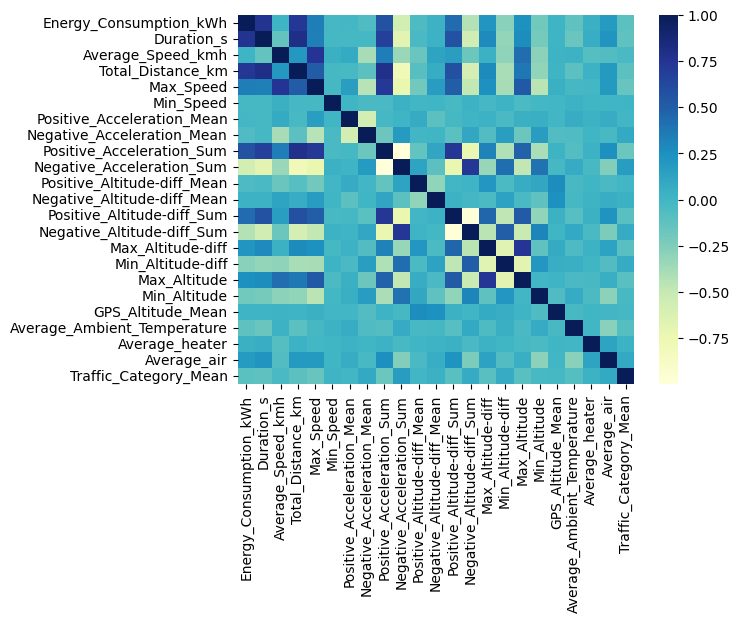

In [76]:
sns.heatmap(trip_metrics_df.corr(), cmap="YlGnBu")

In [57]:
trip_metrics_df.corr()

C:\Users\Yunus\AppData\Local\Temp\ipykernel_18332\3785192019.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  trip_metrics_df.corr()


,Energy_Consumption_kWh,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,Negative_Acceleration_Mean,Positive_Acceleration_Sum,Negative_Acceleration_Sum,...,Negative_Altitude-diff_Sum,Max_Altitude-diff,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_heater,Average_air,Traffic_Category_Mean
Energy_Consumption_kWh,1.000000,0.753431,0.018181,0.726569,0.342603,-0.015966,-0.006961,-0.059849,0.529518,-0.532641,...,-0.430145,0.214231,-0.268597,0.249752,-0.181185,0.010622,-0.113151,0.040351,0.187272,-0.104097
Duration_s,0.753431,1.000000,-0.126823,0.783781,0.323868,-0.016886,-0.023126,-0.016358,0.623490,-0.626354,...,-0.554568,0.260186,-0.275037,0.263811,-0.182372,0.009346,-0.148906,0.060616,0.222914,-0.120452
Average_Speed_kmh,0.018181,-0.126823,1.000000,0.214007,0.743462,0.052416,0.081953,-0.376028,0.316138,-0.314027,...,-0.168717,0.037014,-0.265398,0.399990,-0.282091,0.009231,0.027771,-0.080073,-0.059455,-0.036643
Total_Distance_km,0.726569,0.783781,0.214007,1.000000,0.513517,-0.022120,-0.019645,-0.120680,0.741036,-0.743733,...,-0.576868,0.262930,-0.355091,0.357232,-0.273888,0.008041,-0.090342,0.028063,0.179034,-0.124711
Max_Speed,0.342603,0.323868,0.743462,0.513517,1.000000,-0.017579,0.190738,-0.467362,0.685972,-0.685363,...,-0.496229,0.255166,-0.371601,0.495185,-0.443181,0.033812,0.029362,-0.010470,0.173599,-0.147441
Min_Speed,-0.015966,-0.016886,0.052416,-0.022120,-0.017579,1.000000,-0.000107,-0.028090,-0.030678,0.030844,...,0.024585,-0.015341,0.019452,-0.041318,-0.013670,-0.001521,0.027927,0.004865,0.001356,0.006179
Positive_Acceleration_Mean,-0.006961,-0.023126,0.081953,-0.019645,0.190738,-0.000107,1.000000,-0.603410,0.048247,-0.050285,...,-0.031444,0.072507,-0.086956,0.038294,0.009949,-0.019399,0.138721,0.025290,0.031561,-0.011070
Negative_Acceleration_Mean,-0.059849,-0.016358,-0.376028,-0.120680,-0.467362,-0.028090,-0.603410,1.000000,-0.217292,0.223089,...,0.137765,-0.110028,0.191767,-0.162457,0.194633,-0.044390,-0.126256,0.003931,0.002502,0.086337
Positive_Acceleration_Sum,0.529518,0.623490,0.316138,0.741036,0.685972,-0.030678,0.048247,-0.217292,1.000000,-0.999385,...,-0.734302,0.329820,-0.396716,0.419733,-0.368992,0.016884,0.017654,0.026286,0.197995,-0.177034
Negative_Acceleration_Sum,-0.532641,-0.626354,-0.314027,-0.743733,-0.685363,0.030844,-0.050285,0.223089,-0.999385,1.000000,...,0.734952,-0.331496,0.398696,-0.419412,0.368713,-0.016800,-0.019113,-0.026858,-0.197505,0.176636


In [63]:
trip_metrics_df.corr()

C:\Users\Yunus\AppData\Local\Temp\ipykernel_18332\3785192019.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  trip_metrics_df.corr()


,Energy_Consumption_kWh,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,Negative_Acceleration_Mean,Positive_Acceleration_Sum,Negative_Acceleration_Sum,...,Negative_Altitude-diff_Sum,Max_Altitude-diff,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_heater,Average_air,Traffic_Category_Mean
Energy_Consumption_kWh,1.000000,0.757840,0.010671,0.729877,0.342655,-0.015852,-0.010654,-0.056845,0.568751,-0.572369,...,-0.432930,0.216417,-0.284348,0.249169,-0.195017,0.010493,-0.123676,0.040351,0.188322,-0.101001
Duration_s,0.757840,1.000000,-0.134213,0.798509,0.329851,-0.016899,-0.021185,-0.018957,0.676498,-0.680263,...,-0.562620,0.287221,-0.313924,0.271447,-0.214358,0.009343,-0.158249,0.060616,0.225202,-0.118612
Average_Speed_kmh,0.010671,-0.134213,1.000000,0.195663,0.746816,0.044680,0.081023,-0.383122,0.340163,-0.337764,...,-0.170013,0.035712,-0.301042,0.425440,-0.292181,0.015920,0.030721,-0.079512,-0.066993,-0.037780
Total_Distance_km,0.729877,0.798509,0.195663,1.000000,0.513631,-0.022739,-0.031055,-0.114669,0.782190,-0.785027,...,-0.582756,0.279124,-0.396351,0.372944,-0.305094,0.008623,-0.114329,0.029854,0.189507,-0.113003
Max_Speed,0.342655,0.329851,0.746816,0.513631,1.000000,-0.019626,0.159141,-0.443857,0.723436,-0.722391,...,-0.491810,0.247899,-0.388445,0.527315,-0.459879,0.038282,-0.015846,-0.009239,0.193606,-0.150898
Min_Speed,-0.015852,-0.016899,0.044680,-0.022739,-0.019626,1.000000,0.000944,-0.035004,-0.032311,0.032451,...,0.024408,-0.015359,0.020400,-0.042451,-0.013640,-0.001243,0.029519,0.004945,0.004529,0.011543
Positive_Acceleration_Mean,-0.010654,-0.021185,0.081023,-0.031055,0.159141,0.000944,1.000000,-0.572684,-0.016604,0.015218,...,0.012700,0.027023,-0.037371,0.039168,0.052773,-0.004709,0.067323,0.025290,0.068708,-0.005200
Negative_Acceleration_Mean,-0.056845,-0.018957,-0.383122,-0.114669,-0.443857,-0.035004,-0.572684,1.000000,-0.179301,0.184707,...,0.102566,-0.066707,0.158719,-0.172286,0.173781,-0.065270,-0.056979,0.003931,-0.027341,0.087259
Positive_Acceleration_Sum,0.568751,0.676498,0.340163,0.782190,0.723436,-0.032311,-0.016604,-0.179301,1.000000,-0.999407,...,-0.727911,0.328024,-0.417416,0.480023,-0.402888,0.018213,-0.075164,0.026286,0.257242,-0.172424
Negative_Acceleration_Sum,-0.572369,-0.680263,-0.337764,-0.785027,-0.722391,0.032451,0.015218,0.184707,-0.999407,1.000000,...,0.728713,-0.329235,0.418969,-0.479685,0.402222,-0.018193,0.074883,-0.026858,-0.257256,0.171918


In [19]:
trip_metrics_df.to_csv('trip_metrics_df.csv',index=False)

## 0.7. Find the outliers and nan values

GPS_Speed NaN ratio = 0.198 %
Battery_Voltage_SYS NaN ratio = 0.018 %
Battery_Current_SYS NaN ratio = 0.008 %
Timestamp NaN ratio = 0.000 %
RD_Ambient_Temp_degC NaN ratio = 0.078 %
Total Time(s) NaN ratio = 0.004 %
Power(kW) NaN ratio = 0.021 %


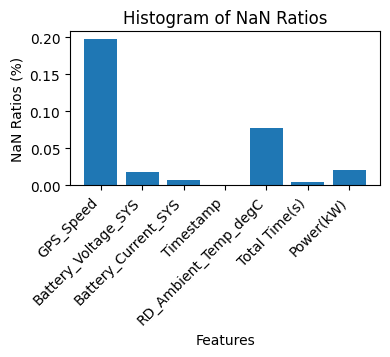

In [234]:
def plot_histogram(nan_ratios, columns):
    plt.figure(figsize=(4, 2))
    plt.bar(columns, nan_ratios)
    plt.xlabel('Features')
    plt.ylabel('NaN Ratios (%)')
    plt.xticks(rotation=45, ha='right')
    plt.title('Histogram of NaN Ratios')
    plt.show()


def display_nan_ratios(df, columns=['GPS_Speed', 'Battery_Voltage_SYS', 'Battery_Current_SYS', 'Timestamp', 'RD_Ambient_Temp_degC', 'Total Time(s)', 'Power(kW)']):
    nan_ratios = []
    for col in columns:
        col_nan_ratio = df[col].isna().sum() / df.shape[0] * 100
        nan_ratios.append(col_nan_ratio)
        print(f"{col} NaN ratio = {col_nan_ratio:.3f} %")
        
    plot_histogram(nan_ratios, columns)

display_nan_ratios(df_merged)


In [235]:
def nan_ratio(x):
    nan_count = x.isna().sum()
    not_nan_count = x.notna().sum()
    ratio = nan_count / (nan_count + not_nan_count)
    return ratio


In [236]:
# groupby ID and calculate NaN ratio for Col1 and Col2
grouped = df_merged.groupby('File_Name', as_index=False)[['GPS_Speed', 'Battery_Voltage_SYS','Battery_Current_SYS', 'RD_Ambient_Temp_degC']].apply(nan_ratio)
grouped = grouped.sort_values(by=['RD_Ambient_Temp_degC','GPS_Speed','Battery_Voltage_SYS','Battery_Current_SYS'], ascending=False)

In [237]:
grouped.to_csv('nan_values.csv',index=False)

In [238]:
def outlier_speed(x,y):
    outlier_count = (x > 50).sum()
    ratio = outlier_count / y
    return ratio

group_s = df_merged.groupby('File_Name', as_index=False)[['GPS_Speed']].apply(outlier_speed,df_merged.shape[0])
group_s

,File_Name,GPS_Speed
0,vehicle_106_device_06A_2013-01-02.mat,0.000012
1,vehicle_106_device_06A_2013-01-03.mat,0.000012
2,vehicle_106_device_06A_2013-01-04.mat,0.000027
3,vehicle_106_device_06A_2013-01-05.mat,0.000083
4,vehicle_106_device_06A_2013-01-07.mat,0.000000
...,...,...
710,vehicle_113_device_071_2014-12-08.mat,0.000079
711,vehicle_113_device_071_2014-12-09.mat,0.000158
712,vehicle_113_device_071_2014-12-16.mat,0.000130
713,vehicle_113_device_071_2014-12-17.mat,0.000033


In [239]:
group_s.to_csv('speed_anomaly.csv',index=False)

In [240]:
def outlier_voltage(x,y):
    outlier_count = (x > 346).sum()
    ratio = outlier_count / y
    return ratio

group_v = df_merged.groupby('File_Name', as_index=False)[['Battery_Voltage_SYS']].apply(outlier_voltage,df_merged.shape[0])
group_v

,File_Name,Battery_Voltage_SYS
0,vehicle_106_device_06A_2013-01-02.mat,0.0
1,vehicle_106_device_06A_2013-01-03.mat,0.0
2,vehicle_106_device_06A_2013-01-04.mat,0.0
3,vehicle_106_device_06A_2013-01-05.mat,0.0
4,vehicle_106_device_06A_2013-01-07.mat,0.0
...,...,...
710,vehicle_113_device_071_2014-12-08.mat,0.0
711,vehicle_113_device_071_2014-12-09.mat,0.0
712,vehicle_113_device_071_2014-12-16.mat,0.0
713,vehicle_113_device_071_2014-12-17.mat,0.0


In [241]:
group_v.to_csv('voltage_anomaly.csv',index=False)

In [242]:
def outlier_power(x,y):
    outlier_count = (x > 80).sum()
    ratio = outlier_count / y
    return ratio

group_p = df_merged.groupby('File_Name', as_index=False)[['Power(kW)']].apply(outlier_power,df_merged.shape[0])
group_p

,File_Name,Power(kW)
0,vehicle_106_device_06A_2013-01-02.mat,0.000102
1,vehicle_106_device_06A_2013-01-03.mat,0.000130
2,vehicle_106_device_06A_2013-01-04.mat,0.000053
3,vehicle_106_device_06A_2013-01-05.mat,0.000075
4,vehicle_106_device_06A_2013-01-07.mat,0.000000
...,...,...
710,vehicle_113_device_071_2014-12-08.mat,0.000077
711,vehicle_113_device_071_2014-12-09.mat,0.000058
712,vehicle_113_device_071_2014-12-16.mat,0.000057
713,vehicle_113_device_071_2014-12-17.mat,0.000009


In [243]:
group_p.to_csv('power_anomaly.csv',index=False)

In [244]:
def outlier_temp(x,y):
    outlier_count = (x > 36).sum() + (x < -15).sum()
    ratio = outlier_count / y
    return ratio

group_t = df_merged.groupby('File_Name', as_index=False)[['RD_Ambient_Temp_degC']].apply(outlier_temp,df_merged.shape[0])
group_t.sort_values(by=['RD_Ambient_Temp_degC'], ascending=False)


,File_Name,RD_Ambient_Temp_degC
0,vehicle_106_device_06A_2013-01-02.mat,0.0
491,vehicle_106_device_06A_2014-10-23.mat,0.0
471,vehicle_106_device_06A_2014-09-27.mat,0.0
472,vehicle_106_device_06A_2014-09-29.mat,0.0
473,vehicle_106_device_06A_2014-09-30.mat,0.0
...,...,...
240,vehicle_106_device_06A_2013-11-13.mat,0.0
241,vehicle_106_device_06A_2013-11-14.mat,0.0
242,vehicle_106_device_06A_2013-11-15.mat,0.0
243,vehicle_106_device_06A_2013-11-16.mat,0.0


In [245]:
group_t.to_csv('temp_anomaly.csv',index=False)

In [246]:
# Get a list of column names
column_names = df_merged.columns.tolist()

# Move 'File' and 'ID' columns to the front of the list
column_names.insert(0, column_names.pop(column_names.index('File_Name')))
column_names.insert(1, column_names.pop(column_names.index('ID')))

# Reorder the DataFrame columns using the updated list
df_merged = df_merged[column_names]


## 0.8. Divide model to train test